# Web Scraping from the SENHAMI automatic weather stations database

In this notebook, we will get a weather variables of SENHAMI's automatic weather stations from filtered dates and using a bit of web scraping.
So let´s get started 

## Importing libraries

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

## Defining our available dates

First of all, the available date are into the [website of SENHAMI's stations](https://senamhi.gob.pe/?&p=estaciones), each station have own available dates. After to review the available date of your station of interest (the available dates appear in the drop-down "Ir" button). You can input the first and last year/month in numeric data 

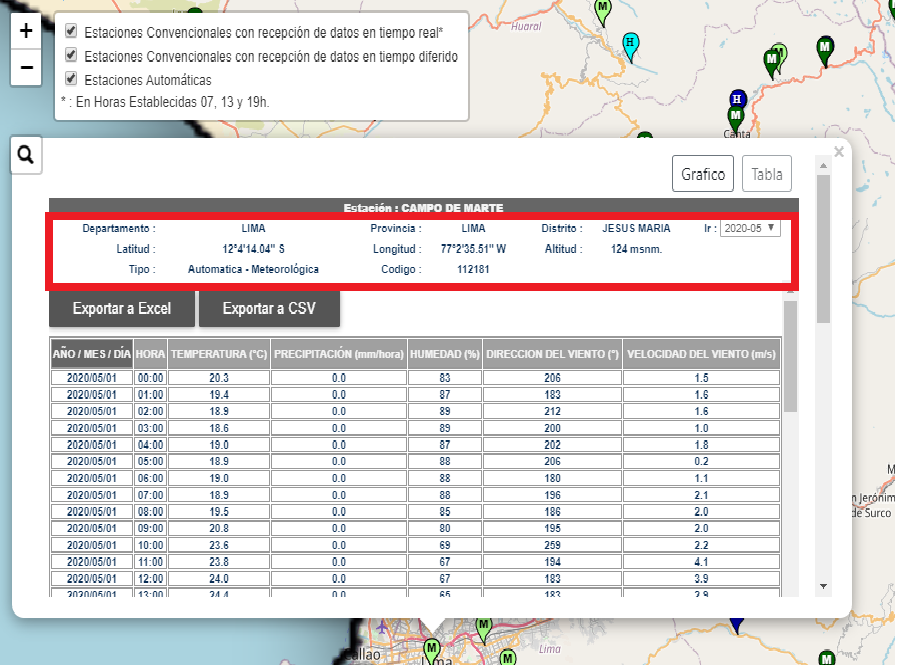

In [2]:
# First year available in the station
print("Digite el año inicial disponible en la estación")
first_year = input()
print(('El año inicial disponible en la estación: {}').format(first_year))

# Last year available in the station
print("\nDigite el año final disponible en la estación")
last_year = input()
print(('El año final disponible en la estación: {}').format(last_year))

# First month available in the station
print("\nDigite el mes inicial disponible en la estación, en números")
first_month =input()
print(('El mes inicial disponible en la estación: {}').format(first_month))

# Last month available in the station
print("\nDigite el mes final disponible en la estación, en números")
last_month =  input()
print(('El mes final disponible en la estación: {}').format(last_month))

Digite el año inicial disponible en la estación
2015
El año inicial disponible en la estación: 2015

Digite el año final disponible en la estación
2020
El año final disponible en la estación: 2020

Digite el mes inicial disponible en la estación, en números
5
El mes inicial disponible en la estación: 5

Digite el mes final disponible en la estación, en números
5
El mes final disponible en la estación: 5


In [3]:
# Generating right date strings for our web scraping
filtro = []
for year in range(int(first_year), int(last_year) + 1):
    if year == int(first_year):
        for month in range(int(first_month), 13):
            if month < 10:
                filtro.append(str(first_year) + '0' + str(month)) 
            else:
                filtro.append(str(first_year) + str(month))
    elif year == int(last_year):
        for month in range(1, int(last_month) + 1):
            if month < 10:
                filtro.append(str(last_year) + '0' + str(month)) 
            else:
                filtro.append(str(last_year) + str(month))  
    else:               
        for month in range(1,13):
            if month < 10:
                filtro.append(str(year) + '0' + str(month))
            else:            
                filtro.append(str(year) + str(month))        

###  Parameters to URL

As well as the available dates, other parameters like code, type of stations are really relevant. The method to obtain is the same to the available dates, you only  access to the website.

In [4]:
# Station code (For it we choose "Campo de Marte" station in Jesús María)
CODIGO = '112181'
#Specifying the filtered date
filtro
# Type of station, in this case automatic
estado = 'AUTOMATICA'
# Optional: The alture of this station
altura = '124'

## Web Scraping 

At this point, we will use a **for** to get a list of all tables through the URL from the SENHAMI's website using filtered dates and the respective parameters. 

Next,  we convert HTML to text format and each row list of each table have splited by comma for each element of row belong a column. For last, we append it  to list called "rows" with wich we've created a dataframe and dropped the duplicate headers of each table.

In [5]:
# List of stored HTML tables
table = []

# Table format in a dictionary 
dicc={'width':"100%", 'border':"1", 'class':"body01", 'bordercolor':"#999999", 
      'cellpadding':"0", 'cellspacing':"1", 'align':"center", 'id':"dataTable"}

# We will make a for to get a list of all available tables
for fecha in filtro:
    url = 'https://senamhi.gob.pe/mapas/mapa-estaciones-2/_dato_esta_tipo02.php?estaciones={}&CBOFiltro={}&t_e=M&estado={}&cod_old=&cate_esta=EMA&alt={}'.format(
          CODIGO,
          fecha,
          estado,
          altura)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table.append(soup.find('table',dicc)) 

In [6]:
# Obtain each row of each table and append it in a list 
rows = []

# We convert HTML to text format and each row list of each table 
# have splited by comma for each element of row belong a column.
for t in table:
    for i in t.find_all('tr',{'aling': "center"}):
        rows.append(i.text.replace(" ","").replace("\n", " ").strip().split()) 
        
# Creating a dataframe        
senhami = pd.DataFrame(rows[1:], columns = rows[0])

# Dropping headers
header = []
for n in range(len(senhami)):
    if senhami.loc[n,].to_list() == senhami.columns.to_list():
        header.append(n) 
senhami = senhami.drop(header,0)
senhami.index = range(len(senhami.index))
senhami

,AÑO/MES/DÍA,HORA,TEMPERATURA(°C),PRECIPITACIÓN(mm/hora),HUMEDAD(%),DIRECCIONDELVIENTO(°),VELOCIDADDELVIENTO(m/s)
0,2015/05/01,00:00,22.3,0.0,75,80,0.0
1,2015/05/01,01:00,22.3,0.0,76,81,0.1
2,2015/05/01,02:00,23.0,0.0,75,214,1.3
3,2015/05/01,03:00,22.1,0.0,80,211,1.1
4,2015/05/01,04:00,21.6,0.0,81,212,2.2
...,...,...,...,...,...,...,...
42741,2020/05/25,17:00,17.4,0.0,87,205,2.2
42742,2020/05/25,18:00,17.1,0.0,90,211,2.2
42743,2020/05/25,19:00,17.1,0.0,89,191,1.8
42744,2020/05/25,20:00,17.0,0.0,89,202,2.4


In [8]:
#Saving to .csv file
senhami.to_csv('campo_de_marte.csv', index = False)